In [1]:
import os, sys, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler
sys.path.append(os.path.dirname(os.getcwd()))
from class_functions_roman_rubin import sim_events
from functions_roman_rubin import sim_fit, filter_band, mag, filter5points, deviation_from_constant
from functions_roman_rubin import model_rubin_roman, fit_rubin_roman
from functions_roman_rubin import read_data, save, tel_roman_rubin, set_photometric_parameters
sys.path.append('/home/anibal-pc/roman_rubin/'+'/photutils/')
# print(os.getcwd()+'/photutils/')
from bandpass import Bandpass
from signaltonoise import calc_mag_error_m5
from photometric_parameters import PhotometricParameters

#astropy
import astropy.units as u
from astropy.table import QTable
from astropy.time import Time
from astropy.coordinates import SkyCoord

#pyLIMA
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.toolbox import time_series
from pyLIMA.simulations import simulator
from pyLIMA.models import PSBL_model
from pyLIMA.models import USBL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.models import PSPL_model
from pyLIMA.fits import TRF_fit
from pyLIMA.fits import DE_fit
from pyLIMA.fits import MCMC_fit
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.outputs import file_outputs

import multiprocessing as mul
import h5py

from tqdm.auto import tqdm
from astropy import constants as const
from astropy import units as u
import math
from astropy.constants import c, L_sun, sigma_sb, M_jup, M_earth, G
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import USBL_model
from pyLIMA.models import PSBL_model
from collections import OrderedDict
from astropy.coordinates import SkyCoord



/home/anibal-pc/roman_rubin
/home/anibal-pc/roman_rubin


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_path = os.path.dirname(os.getcwd())
model='USBL'
path_save_sim= current_path+'/test_sim_fit/'
path_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
path_TRILEGAL_set= current_path+'/TRILEGAL/PB_planet_split_1.csv'
i=18
data_trilegal = pd.read_csv(path_TRILEGAL_set)
data = data_trilegal.iloc[int(i)]
event = sim_events(model, path_ephemerides, path_dataslice, data, i, path_save_sim, path_save_fit)
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16, 'i':27.85, 'z':27.46, 'y':26.68}


separation_0 (float, the binary separation at t0_om)
r_s (float, the ratio of the radial separation s_z over the projected separation)
s_0
a_s (float, the ratio of the microlesing separation over the true (unscaled))axis (semi-major)
v_para (float, the rotation speed along the s_0 axis, i.e. 1/s ds/dt)
v_perp (float, the rotation speed perpendicular to s_0 axis, i.e. dalpha/dt)
v_radial (float, the rotation speed in the z axis, i.e. 1/s ds_z/dt)

In [3]:

def sim_event(i, data, path_ephemerides, path_dataslice, model):
    '''
    i (int): index of the TRILEGAL data set
    data (dictionary): parameters including magnitude of the stars
    path_ephemerides (str): path to the ephemeris of Gaia
    path_dataslice(str): path to the dataslice obtained from OpSims
    model(str): model desired
    '''
    magstar = {'W149': data["W149"], 'u': data["u"], 'g': data["g"], 'r': data["r"],
               'i': data["i"], 'z': data["z"], 'y': data["Y"]}
    ZP = {'W149': 27.615, 'u': 27.03, 'g': 28.38, 'r': 28.16,
          'i': 27.85, 'z': 27.46, 'y': 26.68}
    my_own_creation, dataSlice, LSST_BandPass = tel_roman_rubin(path_ephemerides,
                                                                path_dataslice)
    photParams = set_photometric_parameters(15, 2)
    new_creation = copy.deepcopy(my_own_creation)
    np.random.seed(i)
    t0 = data['t0']
    tE = data['te']


    params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'], 'rho': data['rho'],
              's': data['s'], 'q': data['q'], 'alpha': data['alpha'],
              'piEN': data['piEN'], 'piEE': data['piEE'], 'v_para': data['v_para'], 'v_perp': data['v_perp'], 'v_radial': data['v_radial'],
             'r_s': data['r_s'], 'a_s': data['a_s']}
    # choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
    # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
    my_own_model = USBL_model.USBLmodel(new_creation,
                                        blend_flux_parameter='ftotal',
                                        parallax=['Full',t0], orbital_motion=['Keplerian', t0])
    print(my_own_model.origin)

    my_own_parameters = []
    for key in params:
        my_own_parameters.append(params[key])

    my_own_flux_parameters = []
    fs, G, F = {}, {}, {}
    np.random.seed(i)
    for band in magstar:
        flux_baseline = 10 ** ((ZP[band] - magstar[band]) / 2.5)
        g = np.random.uniform(0, 1)
        f_source = flux_baseline / (1 + g)
        fs[band] = f_source
        G[band] = g
        F[band] = f_source + g * f_source  # flux_baseline
        f_total = f_source * (1 + g)
        if my_own_model.blend_flux_parameter == "ftotal":
            my_own_flux_parameters.append(f_source)
            my_own_flux_parameters.append(f_total)
        else:
            my_own_flux_parameters.append(f_source)
            my_own_flux_parameters.append(f_source * g)

    my_own_parameters += my_own_flux_parameters
    pyLIMA_parameters = my_own_model.compute_pyLIMA_parameters(my_own_parameters)
    simulator.simulate_lightcurve_flux(my_own_model, pyLIMA_parameters)

    for k in range(1, len(new_creation.telescopes)):
        model_flux = my_own_model.compute_the_microlensing_model(new_creation.telescopes[k],
                                                                 pyLIMA_parameters)['photometry']
        new_creation.telescopes[k].lightcurve_flux['flux'] = model_flux
    Roman_band = False
    Rubin_band = False
    for telo in new_creation.telescopes:
        if telo.name == 'W149':
            x = telo.lightcurve_magnitude['time'].value
            y = telo.lightcurve_magnitude['mag'].value
            z = telo.lightcurve_magnitude['err_mag'].value
            m5 = np.ones(len(x)) * 27.6
            X, Y, Z, sigma_5 = filter_band(x, y - 27.4 + ZP[telo.name], z, m5, telo.name)
            telo.lightcurve_magnitude = QTable([X, Y, Z],
                                               names=['time', 'mag', 'err_mag'], units=['JD', 'mag', 'mag'])
            if not len(telo.lightcurve_magnitude['mag']) == 0:
                Roman_band = True
        else:
            X = telo.lightcurve_flux['time'].value
            ym = mag(ZP[telo.name], telo.lightcurve_flux['flux'].value)
            z, y, x, M5 = [], [], [], []
            for k in range(len(ym)):
                m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == telo.name)][k]
                magerr = calc_mag_error_m5(ym[k], LSST_BandPass[telo.name], m5, photParams)[0]
                z.append(magerr)
                y.append(np.random.normal(ym[k], magerr))
                x.append(X[k])
                M5.append(m5)
            X, Y, Z, sigma_5 = filter_band(x, y, z, M5, telo.name)
            telo.lightcurve_magnitude = QTable([X, Y, Z],
                                               names=['time', 'mag', 'err_mag'],
                                               units=['JD', 'mag', 'mag'])

            if not len(telo.lightcurve_magnitude['mag']) == 0:
                Rubin_band = True

    # This first if holds for an event with at least one Roman and Rubin band
    if Rubin_band and Roman_band:
        # This second if holds for a "detectable" event to fit
        if filter5points(pyLIMA_parameters, new_creation.telescopes) and deviation_from_constant(pyLIMA_parameters, new_creation.telescopes):
            print("A good event to fit")
            return my_own_model, pyLIMA_parameters, True
        else:
            print(
                "Not a good event to fit.\nFail 5 points in t0+-tE\nNot have 3 consecutives points that deviate from constant flux in t0+-tE")
            return my_own_model, pyLIMA_parameters, False
    else:
        print("Not a good event to fit since no Rubin band")
        return my_own_model, pyLIMA_parameters, False

In [19]:


data = pd.read_csv('/home/anibal-pc/Downloads/df_trilegal_radios.csv') #Koshimoto model and TRILEGAL
ang_radii_E = []
radii_source = []
tstart_Roman = 2461508.763828608
mlist=[]
dict_micro = {}#'m_planet':[],'m_star':[],'t0': [],'te': [],'u0': [],'rho': [],'piEE': [],'piEN': [],'s':[],'q':[],'alpha':[]}
# for i in tqdm(range(int(1))):#4e+4))):#len(data))):
    # ml = (50*u.M_sun).value
i=0
m_planet = 1.017 *u.M_earth#np.random.uniform(0.0031463518655061432 , 13)* u.M_jup
m_star = 0.08 *u.M_sun#np.random.uniform(1 , 120 )* u.M_sun
q = (m_planet/m_star).decompose()
ml = (m_star+m_planet).decompose().to('M_sun')
# print(ml)
# ml = np.random.uniform((1 * u.M_sun).value, (120 * u.M_sun).value)
# ml = ml*u.M_sun
# print(ml)
DS = (data.iloc[i]['D_S'] * u.pc).to('kpc')
DL = (data.iloc[i]['D_L'] * u.pc).to('kpc')
print(DS, DL)
c = const.c
G = const.G
yr2day = 365.25
pi_rel = ((1 / DL) - (1 / DS))
# print(pi_rel)
k = 4 * G / (c ** 2)
aconv = (180 * 60 * 60 * 1000) / math.pi
theta_E = np.sqrt(k * pi_rel * ml).decompose() * aconv #multiplico por aconv para pasar de rad a mas
print(theta_E)

mu_rel = data.iloc[i]['mu_rel']
tE = float((theta_E/mu_rel)*yr2day)
print('thetaE se lo puede estimar asi con tE', mu_rel*tE/yr2day)

piE = float(pi_rel.value/theta_E)
ang_radii_E.append(theta_E)
Rstar = data['radius'][i]*u.R_sun
theta_s = np.arctan(Rstar/DS).decompose().to('mas').value
radii_source.append(theta_s)


#------------------------------------------------------------------------------------------------
# t0 = np.random.uniform(tstart_Roman,
                       # tstart_Roman + 5 * 365)  # from 100 day before Roman is launched to one year later
u0 = 0.01
rho = float((theta_s/theta_E).value)

print('thetaE se lo puede estimar asi con rho', theta_s/rho)
phi = np.random.uniform(0, np.pi)
piEE = piE * np.cos(phi)
piEN = piE * np.sin(phi)
d = 0.01154775   #orbit semi major axis
s = float(((np.arctan(d*u.au/DL).to('mas'))/(theta_E)).value)

print('la masa es', (m_planet+m_star).to('M_sun'))

print('la masa se la puede estimar asi', ((theta_E/aconv**2)*u.kpc/(k*np.sqrt(piEN**2+piEE**2))).decompose().to('M_sun'))

# print(s)
# print(theta_E)
# s = np.random.uniform(0,np.arctan(d/dl)/theta_E)
t0 = tstart_Roman-30
dict_micro['u0']= u0
dict_micro['te']= tE
dict_micro['rho'] = rho
dict_micro['piEE']= piEE
dict_micro['piEN']= piEN
dict_micro['t0'] = t0
dict_micro['q'] = q.value
dict_micro['s'] = s
dict_micro['alpha'] = np.random.uniform(0,np.pi)
dict_micro['m_planet'] = m_planet
dict_micro['m_star'] =m_star    
for key in ['u','g','r','i','z','Y','W149']:
    dict_micro[key] = data.iloc[0][key]

mass_kg = (pi_rel/(k*(pi_rel/theta_E)**2)).decompose()
# print(mass_kg.to('M_sun'))
# print((theta_E/aconv)**2)
# print((((theta_E/aconv)**2)/(k*pi_rel)).decompose().to('M_sun'))
mlist.append((((theta_E/aconv)**2)/(k*pi_rel)).decompose().to('M_sun'))


T = (1.51087637*u.day).to('year') #orbital period
sz = 0

r_s = sz/s
a_s = 1
print(r_s, a_s)

# Compute orbital frequency using Kepler's third law
n = 2 * np.pi / T

# Compute denominator of equation (A5)
denominator = a_s * np.sqrt((-1 + 2 * a_s) * (1 + r_s**2))
print(denominator)
# Compute the required velocity magnitude
velocity_magnitude = n * denominator
print(velocity_magnitude)


# Sample random velocity components that satisfy the magnitude constraint
def sample_velocities(magnitude):
    while True:
        gamma = np.random.normal(size=3)  # Sample from normal distribution
        gamma *= magnitude / np.linalg.norm(gamma)  # Normalize to correct magnitude
        return gamma

# Generate a valid velocity set
gamma1, gamma2, gamma3 = sample_velocities(velocity_magnitude.value)

# Output results
print(f"Sampled velocities: γ1 = {gamma1:.4f}, γ2 = {gamma2:.4f}, γ3 = {gamma3:.4f}")
print(np.sqrt(gamma1**2 +gamma2**2+ gamma3**2))
print(velocity_magnitude)

v_para = gamma1
v_perp = gamma2
v_radial = gamma3
dict_micro['v_para'] = v_para
dict_micro['v_perp'] = v_perp
dict_micro['v_radial'] = v_radial
dict_micro['r_s'] = r_s
dict_micro['a_s'] = a_s

f_source = 12.34567
f_blend = 1.234456

# params = [ dict_micro['t0'][0], dict_micro['u0'][0], dict_micro['te'][0], dict_micro['rho'][0],
#           dict_micro['s'][0],dict_micro['q'][0], np.pi/4, dict_micro['piEN'][0], dict_micro['piEE'][0] , v_para, v_perp, v_radial, r_s ,a_s, f_source, f_blend]
# print(params)
# pyLIMA_parameters = usbl.compute_pyLIMA_parameters(params , fancy_parameters=False)
# print(pyLIMA_parameters)

print(dict_micro)

7.708 kpc 3.337 kpc
0.3327435928476573
thetaE se lo puede estimar asi con tE 0.3327435928476573
thetaE se lo puede estimar asi con rho 0.3327435928476573
la masa es 0.08000305454866778 solMass
la masa se la puede estimar asi 0.08000305454866777 solMass
0.0 1
1.0
1518.9419061781632 1 / yr
Sampled velocities: γ1 = 597.5976, γ2 = 1324.4514, γ3 = -442.5948
1518.9419061781632
1518.9419061781632 1 / yr
{'u0': 0.01, 'te': 69.35556337927768, 'rho': 0.0003711917751133969, 'piEE': 0.37857319821102675, 'piEN': 0.34279094646874747, 't0': 2461478.763828608, 'q': 3.81818583472657e-05, 's': 0.010399955112919804, 'alpha': 0.9728969214338847, 'm_planet': <Quantity 1.017 earthMass>, 'm_star': <Quantity 0.08 solMass>, 'u': 27.94, 'g': 25.112, 'r': 23.791, 'i': 23.052, 'z': 22.687, 'Y': 22.509, 'W149': 22.4888, 'v_para': 597.5976191320055, 'v_perp': 1324.4513713438716, 'v_radial': -442.5948089361739, 'r_s': 0.0, 'a_s': 1}


In [5]:
from functions_roman_rubin import mag
current_path = os.path.dirname(os.getcwd())
# print(current_path)
i=18 #select one event by its index in the TRILEGAL set
model='USBL'

path_TRILEGAL_set= current_path+'/TRILEGAL/PB_planet_split_1.csv'
path_to_save_model= current_path+'/test_sim_fit/'
path_to_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
path_fit_rr = path_to_save_fit+f'/Event_RR_{i}_TRF.npy'
path_fit_roman =  path_to_save_fit+f'/Event_Roman_{i}_TRF.npy'
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

# pd_planets = pd.read_csv(path_TRILEGAL_set)
# event_params = pd_planets.iloc[int(i)]
# print(event_params)

my_own_model, pyLIMA_parameters, decision = sim_event(i, dict_micro, path_ephemerides, path_dataslice,model)

/home/anibal-pc/roman_rubin


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope W149: SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 12 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 12 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 12 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERF

Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
['center_of_mass', [0, 0]]
A good event to fit


In [6]:
# mag

In [7]:
pyLIMA_parameters

OrderedDict([('t0', 2461478.763828608),
             ('u0', 0.001),
             ('tE', 69.35556337927768),
             ('rho', 0.0003711917751133969),
             ('separation', 0.010399955112919804),
             ('mass_ratio', 3.81818583472657e-05),
             ('alpha', 1.7348259382356195),
             ('piEN', 0.25431602131474434),
             ('piEE', 0.4428844778125596),
             ('v_para', 511.1611540154773),
             ('v_perp', 627.1573851827816),
             ('v_radial', -1285.5241744830837),
             ('r_s', 0.0),
             ('a_s', 1),
             ('fsource_W149', 68.06088050063036),
             ('ftotal_W149', 112.3259240483568),
             ('fsource_u', 0.28729805823344473),
             ('ftotal_u', 0.4325138310350087),
             ('fsource_g', 10.798547474633631),
             ('ftotal_g', 20.28616716966295),
             ('fsource_r', 47.319618255935666),
             ('ftotal_r', 55.924228304089986),
             ('fsource_i', 44.823355654644

In [8]:
save(i, path_TRILEGAL_set, path_to_save_model, my_own_model, pyLIMA_parameters)

Saving...
File saved: /home/anibal-pc/roman_rubin/test_sim_fit/Event_18.h5


In [9]:
info_dataset, pyLIMA_p, bands = read_data(path_to_save_model+'/Event_18.h5')
# pyLIMA_parameters

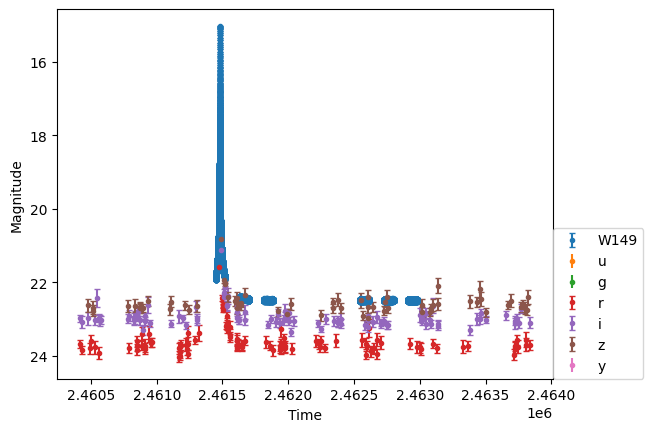

In [10]:

telescopes = my_own_model.event.telescopes

for telo in telescopes:
    plt.errorbar(telo.lightcurve_magnitude['time'],telo.lightcurve_magnitude['mag'],telo.lightcurve_magnitude['err_mag'],ls='',marker='.',capsize=2,label=telo.name)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc=(1,0))
plt.gca().invert_yaxis()
plt.show()


In [11]:
PAR = ['t0','u0','tE','rho','separation','mass_ratio','alpha','piEN','piEE','v_para', 'v_perp','v_radial','r_s','a_s']
ulens_params = []
for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []

# Here we change the zero point to the pyLIMA convention in order to make the alignment
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params
true_params

[2461478.763828608,
 0.001,
 69.35556337927768,
 0.0003711917751133969,
 0.010399955112919804,
 3.81818583472657e-05,
 1.7348259382356195,
 0.25431602131474434,
 0.4428844778125596,
 511.1611540154773,
 627.1573851827816,
 -1285.5241744830837,
 0.0,
 1,
 55.833848427139344,
 92.14674526134338,
 23.49855907985876,
 27.7715423588466,
 29.614497398737942,
 54.852951394120254,
 43.866009742427764,
 76.7714953769026]

In [12]:
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.toolbox import time_series
from pyLIMA.simulations import simulator
from pyLIMA.models import PSBL_model
from pyLIMA.models import USBL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.models import PSPL_model
from pyLIMA.fits import TRF_fit
from pyLIMA.fits import DE_fit
from pyLIMA.fits import MCMC_fit
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.outputs import file_outputs

def model_rubin_roman(Source, true_model, event_params, path_ephemerides, model, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z, lsst_y):
    '''
    Perform fit for Rubin and Roman data for fspl, usbl and pspl
    '''
    
    tlsst = 60350.38482057137 + 2400000.5
    RA, DEC = 267.92497054815516, -29.152232510353276
    e = event.Event(ra=RA, dec=DEC)

    if len(lsst_u) + len(lsst_g) + len(lsst_r) + len(lsst_i) + len(lsst_z) + len(lsst_y) == 0:
        e.name = 'Event_Roman_' + str(int(Source))
        name_roman = 'Roman (Roman)'
    else:
        e.name = 'Event_RR_' + str(int(Source))
        name_roman = 'Roman (Roman+Rubin)'
    tel_list = []

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name=name_roman, camera_filter='W149',
                                light_curve=wfirst_lc,
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Space')

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:, 0] = ephemerides[:, 0]
    ephemerides[:, 3] *= 60 * 300000 / 150000000
    deltaT = tlsst - ephemerides[:, 0][0]
    ephemerides[:, 0] = ephemerides[:, 0] + deltaT
    tel1.spacecraft_positions = {'astrometry': [], 'photometry': ephemerides}
    e.telescopes.append(tel1)
    tel_list.append('Roman')
    
    lsst_lc_list = [lsst_u, lsst_g, lsst_r, lsst_i, lsst_z, lsst_y]
    lsst_bands = "ugrizy"
    for j in range(len(lsst_lc_list)):
        if len(lsst_lc_list[j]) != 0:
            tel = telescopes.Telescope(name=lsst_bands[j]+' (Rubin)', camera_filter=lsst_bands[j],
                                       light_curve=lsst_lc_list[j],
                                       light_curve_names=['time', 'mag', 'err_mag'],
                                       light_curve_units=['JD', 'mag', 'mag'],
                                       location='Earth')
            e.telescopes.append(tel)
            tel_list.append(lsst_bands[j])
    
    e.check_event()
    
    # Use t_center if available; otherwise, use t0
    t_guess = float(event_params['t_center']) if 't_center' in event_params else float(event_params.get('t0', None))

    # Check if model is specified and create the appropriate model instance
    pyLIMAmodel = USBL_model.USBLmodel(e,
                                       blend_flux_parameter='ftotal',
                                       parallax=['Full', t_guess], orbital_motion=['Keplerian', t0])
    return pyLIMAmodel


In [13]:
model_ulens = 'USBL'

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
event_params['s']=event_params['separation']
event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)


check_event  : Everything looks fine...


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope r (Rubin): SUCCESS
Parallax(Full) estimated for the telescope i (Rubin): SUCCESS
Parallax(Full) estimated for the telescope z (Rubin): SUCCESS
Parallax(Full) estimated for the telescope y (Rubin): SUCCESS


/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 32 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 32 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 32 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 42 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal-pc/anaconda3/envs/pyLIMA/lib/python3.9/site-packages/erfa/core.py:133: ErfaWarning: ERF

In [14]:

# if len(true_params) != len(model_true.model_dictionnary):
#     telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
#     telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
#                          telescopes_fluxes]#._fields]
#     model_parameters3 = np.r_[true_params, telescopes_fluxes]
# else:
#     model_parameters3 = true_params


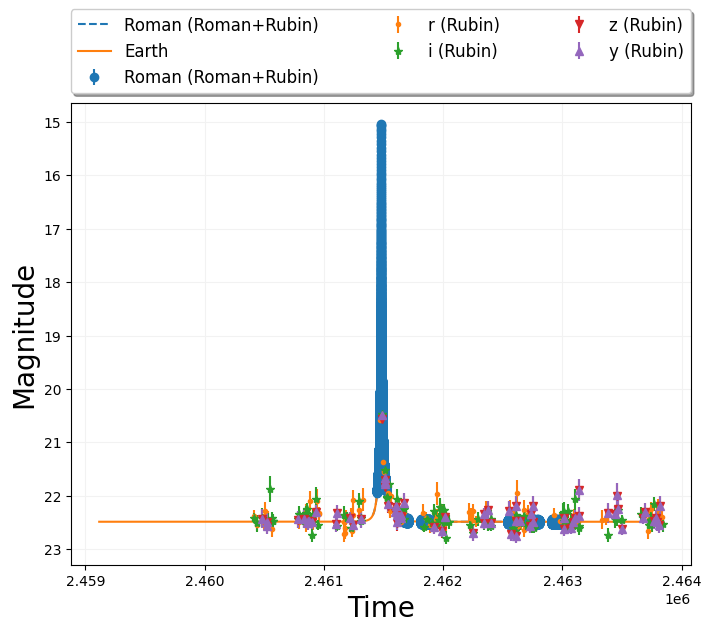

In [18]:
fig, axes = plt.subplots(1, 1,figsize=(8,6))

axes.set_ylabel("Magnitude",fontsize=20)
axes.set_xlabel("Time",fontsize=20)
axes.grid(True, color='0.95')
axes.invert_yaxis()
# axes.set_title('Simulated event')

pyLIMA_plots.plot_photometric_models(axes, model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes, model_true, true_params, plot_unit='Mag')
colors = ['darkslategray', 'gray', 'lightgray']

axes.legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()

(<Figure size 750x750 with 1 Axes>, None)

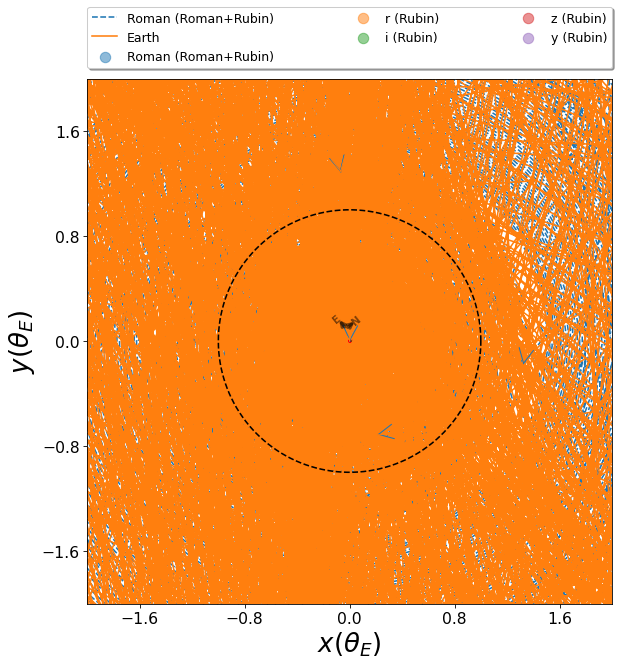

In [16]:
pyLIMA_plots.plot_geometry( model_true, true_params)
# pyLIMA_plots.plot_geometry(usbl, fit_2.fit_results['best_model'])